In [2]:
pip install pandas nltk

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"subhiksha28","key":"7d8165e0e1d3e41d6ff1eb88b707c82a"}'}

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 85% 69.0M/80.9M [00:00<00:00, 178MB/s]
100% 80.9M/80.9M [00:00<00:00, 173MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Ensure NLTK data is available
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Assign column names
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Keep only the 'target' and 'text' columns
df = df[['target', 'text']]

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Clean the text in the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Tokenize the text
df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Display the first few rows of the processed dataframe
print(df.head())

   target                                               text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  \
0  a that s a bummer you shoulda got david carr o...   
1  is upset that he can t update his facebook by ...   
2  i dived many times for the ball managed to sav...   
3     my whole body feels itchy and like its on fire   
4  no it s not behaving at all i m mad why am i h...   

                                      tokenized_text  
0    [bummer, shoulda, got, david, carr, third, day]  
1  [upset, update, facebook, texting, might, cry,...  
2  [dived, many, times, ball, managed, save, 50, ...  
3            [whole, body, feels, itchy, like, fire]  
4  

In [5]:
df

,target,text,cleaned_text,tokenized_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a that s a bummer you shoulda got david carr o...,"[bummer, shoulda, got, david, carr, third, day]"
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,"[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,"[dived, many, times, ball, managed, save, 50, ..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...,"[behaving, mad, see]"
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,"[woke, school, best, feeling, ever]"
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com very cool to hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interviews]"
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,"[ready, mojo, makeover, ask, details]"
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time tup...,"[happy, 38th, birthday, boo, alll, time, tupac..."


from matplotlib import pyplot as plt
df['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['target']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'target'}, axis=1)
              .sort_values('target', ascending=True))
  xs = counted['target']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('target', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('target')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['target'].plot(kind='line', figsize=(8, 4), title='target')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
# Check the distribution of sentiments
sentiment_counts = df['target'].value_counts()
print("Sentiment Distribution:")
print(sentiment_counts)

# Display the count of positive and negative samples
negative_count = sentiment_counts[0]
positive_count = sentiment_counts[4]

print(f"\nNumber of negative samples: {negative_count}")
print(f"Number of positive samples: {positive_count}")

# Display positive and negative tables separately
positive_df = df[df['target'] == 4]
negative_df = df[df['target'] == 0]

print("\nPositive Sentiment Table:")
print(positive_df.head())

print("\nNegative Sentiment Table:")
print(negative_df.head())

Sentiment Distribution:
target
0    800000
4    800000
Name: count, dtype: int64

Number of negative samples: 800000
Number of positive samples: 800000

Positive Sentiment Table:
        target                                               text  \
800000       4       I LOVE @Health4UandPets u guys r the best!!    
800001       4  im meeting up with one of my besties tonight! ...   
800002       4  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003       4  Being sick can be really cheap when it hurts t...   
800004       4    @LovesBrooklyn2 he has that effect on everyone    

                                             cleaned_text  \
800000                           i love u guys r the best   
800001  im meeting up with one of my besties tonight c...   
800002  thanks for the twitter add sunisa i got to mee...   
800003  being sick can be really cheap when it hurts t...   
800004                     he has that effect on everyone   

                                       

<ipython-input-7-67bde1fc8865>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


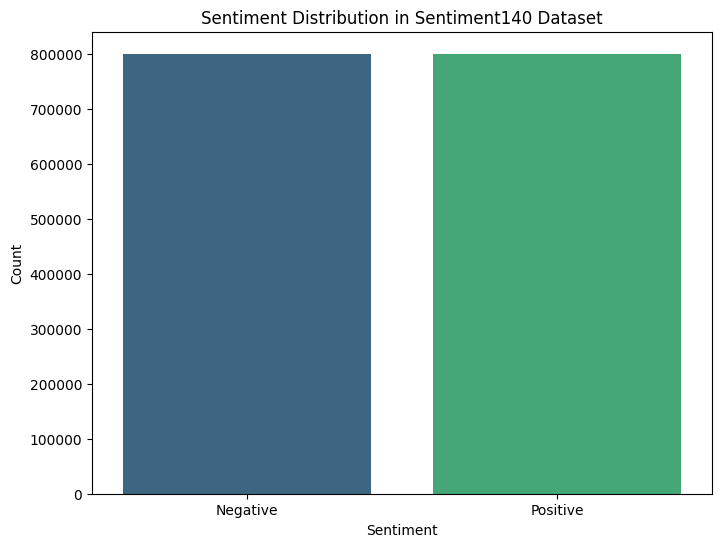

In [7]:
# Create a bar plot for sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Sentiment140 Dataset')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

In [8]:
# Rename the 'target' column to 'Sentiment polarity'
df.rename(columns={'target': 'Sentiment polarity'}, inplace=True)

df

,Sentiment polarity,text,cleaned_text,tokenized_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a that s a bummer you shoulda got david carr o...,"[bummer, shoulda, got, david, carr, third, day]"
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,"[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,"[dived, many, times, ball, managed, save, 50, ..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...,"[behaving, mad, see]"
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,"[woke, school, best, feeling, ever]"
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,thewdb com very cool to hear old walt interviews,"[thewdb, com, cool, hear, old, walt, interviews]"
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,"[ready, mojo, makeover, ask, details]"
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time tup...,"[happy, 38th, birthday, boo, alll, time, tupac..."


In [1]:
# Extract features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()

# Target variable
y = df['Sentiment polarity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict on test data
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

NameError: name 'TfidfVectorizer' is not defined